In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from collections import Counter
import seaborn as sns
import random
import pickle 
from functools import partial
import matplotlib.pyplot as plt

from src.data.utils import flatten, parallelize_dataframe
from src.data.scrape_categories import EMOJI_CATEGORIES as emoji_categories
from src.analysis.embedded import calculate_cldr_distance, embedded_CIs
from src.data.cldr import cldr_anns_to_df
from src.visualization.emoji_plotting import plot_emoji_barplot, emoji_scatter
from settings import CLDR_DISTANCE, AMBIGUITY_VARIATION, EMOJI_CATEGORIZED

pd.set_option('mode.chained_assignment', None)

sns.set(rc={'figure.figsize':(15, 7)}, font_scale=1.3)
sns.set_style("white", {'axes.grid' : False})
random.seed(7)

### Read pre calculated CIs

In [2]:
cldr = pd.read_csv(CLDR_DISTANCE)
cldr.CIs = cldr.CIs.apply(eval)

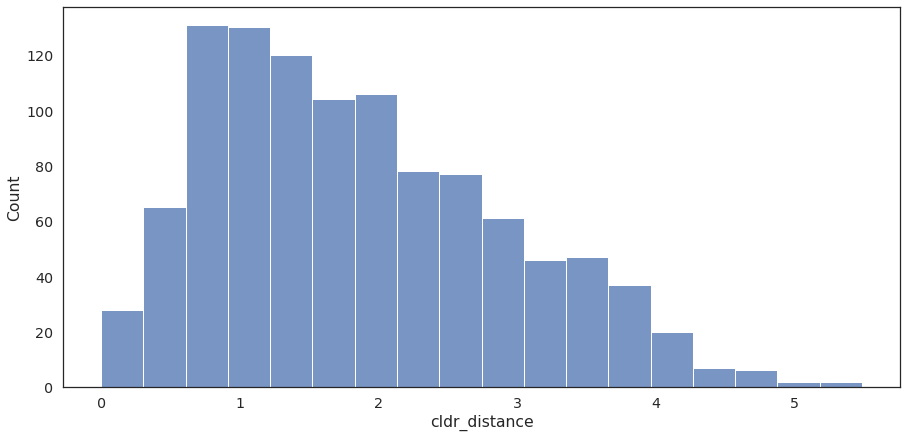

In [3]:
sns.histplot(data=cldr.cldr_distance);

In [4]:
cldr.describe()

,cldr_distance
count,1067.000000
mean,1.862324
std,1.064480
min,0.000000
25%,0.991009
50%,1.703021
75%,2.604193
max,5.486946


In [5]:
cldr.sort_values(by="cldr_distance")[:10]

,emoji,vocabulary,cldr_description,words,cldr_distance,CIs
199,🍿,Counter({'popcorn': 28}),{'popcorn'},{'popcorn'},0.000000,"[0.0, 0.0]"
290,🐄,Counter({'cow': 30}),{'cow'},{'cow'},0.000000,"[0.0, 0.0]"
766,🚪,"Counter({'door': 29, 'house': 1})",{'door'},"{'house', 'door'}",0.015094,"[0.0, 0.04528128504753113]"
297,🐋,"Counter({'whale': 29, 'fish': 1})",{'whale'},"{'fish', 'whale'}",0.015238,"[0.0, 0.045714920759201055]"
785,🚽,"Counter({'toilet': 28, 'closet': 1})",{'toilet'},"{'closet', 'toilet'}",0.020875,"[0.0, 0.06262365497391799]"
291,🐅,"Counter({'tiger': 27, 'lion': 2})",{'tiger'},"{'lion', 'tiger'}",0.027394,"[0.0, 0.06848600404015903]"
311,🐘,"Counter({'elephant': 26, 'truth': 1})",{'elephant'},"{'elephant', 'truth'}",0.028246,"[0.0, 0.08473778598838382]"
58,⭐,"Counter({'star': 29, 'christmas': 1, 'great': 1})",{'star'},"{'star', 'christmas', 'great'}",0.033592,"[0.0, 0.08455115268307348]"
304,🐒,"Counter({'monkey': 29, 'curious': 1, 'waiting'...",{'monkey'},"{'curious', 'waiting', 'monkey'}",0.041871,"[0.0, 0.10527210274050314]"
298,🐌,"Counter({'snail': 27, 'smile': 1, 'slow': 1})",{'snail'},"{'slow', 'smile', 'snail'}",0.050004,"[0.0, 0.12183909786158595]"


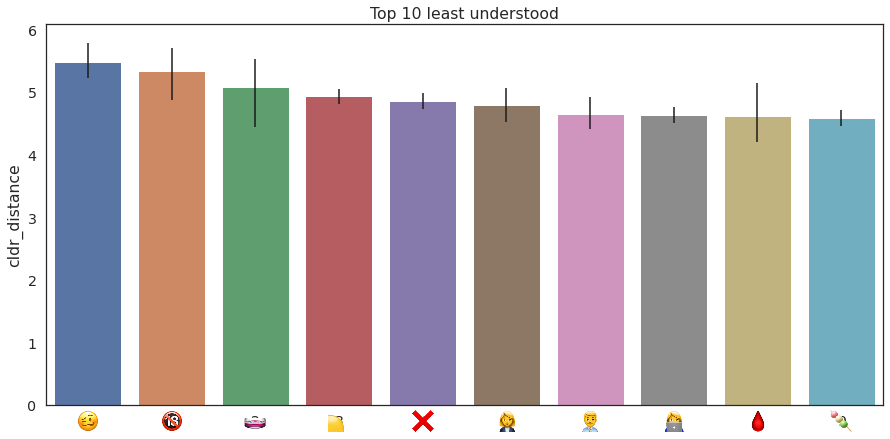

In [6]:
fig, ax = plt.subplots()
top_ten = cldr.sort_values("cldr_distance", ascending=False)[:10].reset_index()
col = "cldr_distance"
plot_emoji_barplot(top_ten, ax, col)
ax.set_title(f"Top 10 least understood");

In [7]:
top_ten[["emoji", "cldr_description", "vocabulary"]]

,emoji,cldr_description,vocabulary
0,🥴,"{'dizzy', 'mouth', 'eyes', 'uneven', 'woozy', ...","Counter({'confused': 5, 'crazy': 3, 'sad': 3, ..."
1,🔞,"{'18', 'underage', 'prohibited', 'one', 'restr...","Counter({'no': 4, 'underage': 4, 'restricted':..."
2,🧫,"{'lab', 'dish', 'biology', 'bacteria', 'petri'...","Counter({'soup': 5, 'bowl': 4, 'petri': 3, 'fo..."
3,🦲,"{'hairless', 'hair', 'no', 'bald', 'shaven', '...","Counter({'quarter': 9, 'cheese': 4, 'sun': 4, ..."
4,❌,"{'cancel', 'multiplication', 'multiply', 'x', ...","Counter({'no': 7, 'x': 7, 'wrong': 6, 'cross':..."
5,👩‍💼,"{'worker', 'manager', 'woman', 'office', 'arch...","Counter({'businesswoman': 6, 'teacher': 2, 'pr..."
6,👨‍💼,"{'worker', 'manager', 'office', 'man', 'archit...","Counter({'businessman': 6, 'presentation': 5, ..."
7,👩‍💻,"{'developer', 'software', 'woman', 'coder', 'i...","Counter({'laptop': 10, 'reading': 2, 'worker':..."
8,🩸,"{'drop', 'donation', 'bleed', 'medicine', 'blo...","Counter({'blood': 19, 'droplet': 2, 'light': 1..."
9,🍡,"{'skewer', 'stick', 'dango', 'Japanese', 'swee...","Counter({'candy': 6, 'kabob': 3, 'dango': 3, '..."


In [8]:
with open(EMOJI_CATEGORIZED, "rb") as f:
    categorized = pickle.load(f)

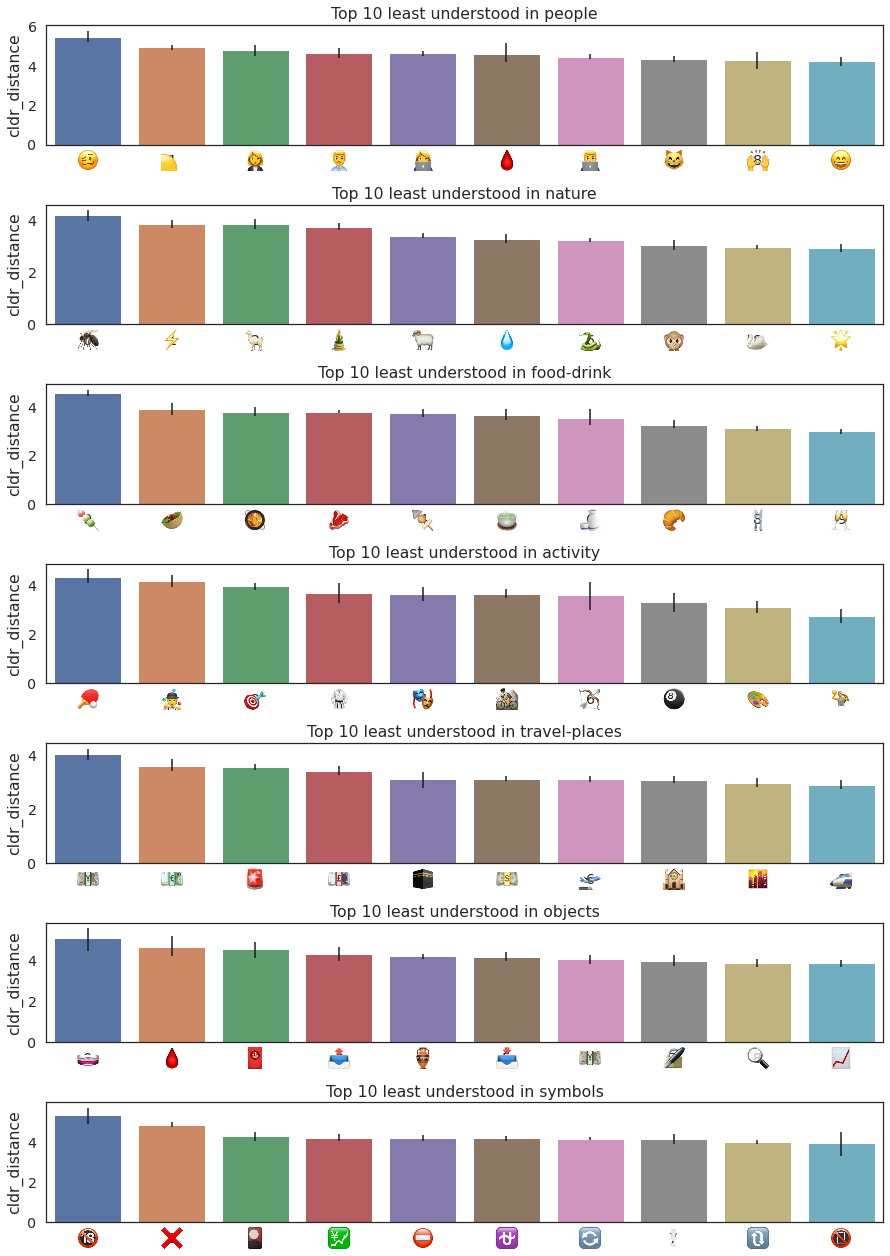

In [9]:
fig, axes = plt.subplots(7, 1)
for i, ax in enumerate(axes):
    category = emoji_categories[i]
    df = cldr[cldr.emoji.isin(categorized[category])]
    top_ten = df.sort_values("cldr_distance", ascending=False)[:10].reset_index()
    plot_emoji_barplot(top_ten, ax, col='cldr_distance')
    ax.set_title(f"Top 10 least understood in {category}")
plt.subplots_adjust(wspace=0.2, hspace=0.5, top=2.5)

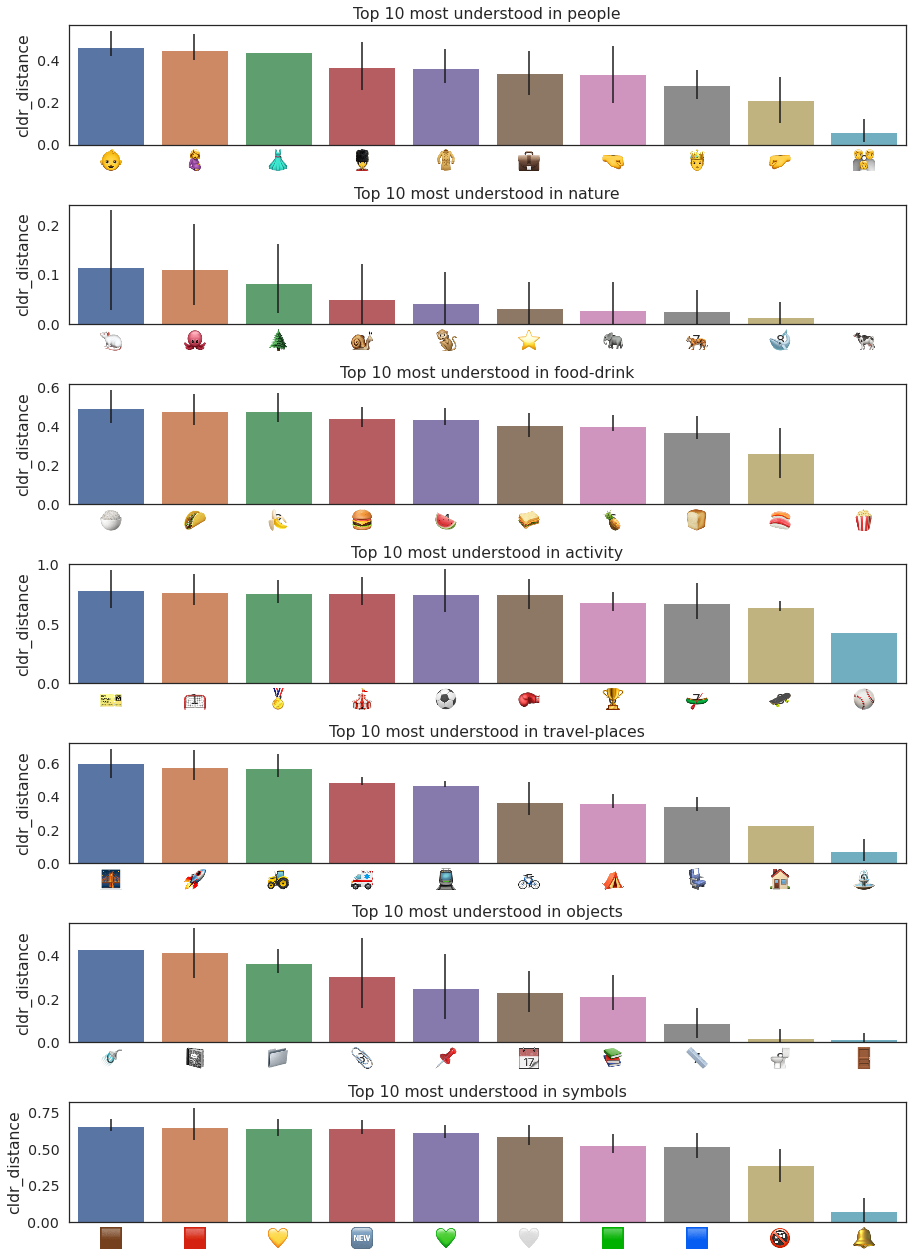

In [10]:
fig, axes = plt.subplots(7, 1)
for i, ax in enumerate(axes):
    category = emoji_categories[i]
    df = cldr[cldr.emoji.isin(categorized[category])]\
            .sort_values("cldr_distance", ascending=False)[-10:].reset_index()
    plot_emoji_barplot(df, ax, col='cldr_distance')
    ax.set_title(f"Top 10 most understood in {category}")
plt.subplots_adjust(wspace=0.2, hspace=0.5, top=2.5)

In [11]:
pd.set_option('display.max_colwidth', None)
category = 'people'
df = cldr[cldr.emoji.isin(categorized[category])]
df.sort_values("cldr_distance", ascending=False)[-10:].reset_index()[["emoji", "vocabulary", "cldr_description"]]

,emoji,vocabulary,cldr_description
0,👶,"Counter({'baby': 25, 'tooth': 1})","{'baby', 'young'}"
1,🤰,"Counter({'pregnant': 23, 'expecting': 1, 'pregnancy': 1})","{'woman', 'pregnant'}"
2,👗,Counter({'dress': 30}),"{'clothing', 'dress'}"
3,💂,"Counter({'soldier': 10, 'guard': 10, 'police': 1, 'brigade': 1, 'worker': 1, 'server': 1, 'solider': 1, 'bellhop': 1, 'britain': 1})",{'guard'}
4,🧥,"Counter({'jacket': 15, 'coat': 8, 'shirt': 2, 'sweater': 2, 'pullover': 1, 'winter': 1, 'cold': 1})","{'jacket', 'coat'}"
5,💼,"Counter({'briefcase': 11, 'suitcase': 7, 'bag': 5, 'breifcase': 2, 'satchel': 1, 'office bag': 1, 'business': 1, 'luggage': 1, 'purse': 1})",{'briefcase'}
6,🤜,"Counter({'fist': 14, 'fistbump': 7, 'punch': 3, 'pound': 2, 'awesome': 1, 'dap': 1})","{'fist', 'rightwards', 'right-facing'}"
7,🤴,"Counter({'king': 19, 'prince': 5, 'crown': 2, 'doctor': 1, 'queen': 1, 'godly': 1})",{'prince'}
8,🤛,"Counter({'fist': 20, 'fistbump': 4, 'punch': 3, 'agree': 1, 'first': 1, 'fist pump': 1})","{'fist', 'left-facing', 'leftwards'}"
9,👪,"Counter({'family': 25, 'happy': 1, 'people': 1, 'crowd': 1, 'group': 1})",{'family'}


In [12]:
cldr['vocab_size'] = 0
for i, row in cldr.iterrows():
    row = row.copy()
    cldr.loc[i, "vocab_size"] = len(eval(row.vocabulary).keys())
cldr.head()

,emoji,vocabulary,cldr_description,words,cldr_distance,CIs,vocab_size
0,⌚,"Counter({'watch': 23, 'time': 6, 'timing': 1})","{'watch', 'clock'}","{'time', 'timing', 'watch'}",0.624514,"[0.5697174459695816, 0.6899223665396372]",3
1,⌛,"Counter({'hourglass': 15, 'time': 7, 'timer': 4, 'loading': 1, 'cup': 1, 'sand glass': 1, 'brain': 1})","{'hourglass', 'done', 'timer', 'sand'}","{'loading', 'cup', 'timer', 'time', 'hourglass', 'glass', 'brain', 'sand'}",2.501467,"[2.435779988765716, 2.585777521353836]",7
2,⏩,"Counter({'forward': 17, 'fastforward': 3, 'arrow': 2, 'play': 2, 'next': 1, 'backward': 1, 'ahead': 1})","{'double', 'button', 'fast', 'forward', 'fast-forward', 'arrow'}","{'backward', 'ahead', 'fastforward', 'next', 'forward', 'play', 'arrow'}",2.727542,"[2.493434014861231, 2.9851059622165783]",7
3,⏪,"Counter({'rewind': 17, 'back': 3, 'left': 3, 'backward': 2, 'backwards': 2, 'forward': 1})","{'rewind', 'double', 'button', 'fast', 'reverse', 'arrow'}","{'rewind', 'backwards', 'left', 'backward', 'back', 'forward'}",3.594499,"[3.45401383693596, 3.7597666664115548]",6
4,⏫,"Counter({'up': 11, 'upward': 3, 'ahead': 2, 'rewind': 1, 'fast': 1, 'up arrow': 1, 'upload': 1, 'back to top': 1, 'higher': 1, 'forest': 1, 'upwards': 1, 'top': 1, 'forward': 1})","{'double', 'button', 'fast', 'up', 'arrow'}","{'to', 'higher', 'rewind', 'forest', 'ahead', 'back', 'upward', 'upload', 'fast', 'top', 'forward', 'up', 'upwards', 'arrow'}",2.729409,"[2.452992368145631, 3.03556271499166]",13


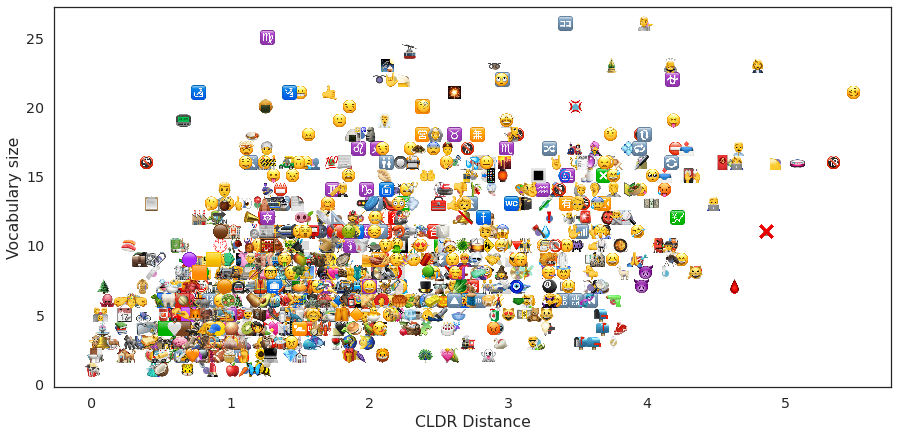

In [13]:
fig, ax = plt.subplots()
df = cldr
for x, y, emoji in zip(df['cldr_distance'], df['vocab_size'], df['emoji']):
    emoji_scatter(x, y, emoji, zoom=0.2, ax=ax)
    ax.scatter(x, y)
ax.set_xlabel("CLDR Distance")
ax.set_ylabel("Vocabulary size");

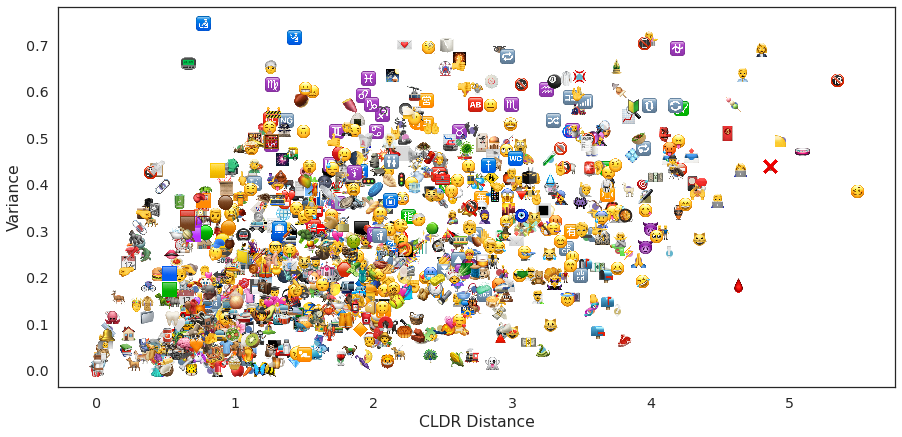

In [14]:
variances = pd.read_csv(AMBIGUITY_VARIATION)
variances.CIs = variances.CIs.apply(eval)
df = variances[["emoji", "variation"]].merge(cldr[["emoji", "cldr_distance"]], on='emoji')
fig, ax = plt.subplots()
for x, y, emoji in zip(df['cldr_distance'], df['variation'], df['emoji']):
    emoji_scatter(x, y, emoji, zoom=0.2, ax=ax)
    ax.scatter(x, y)
ax.set_xlabel("CLDR Distance")
ax.set_ylabel("Variation");